In [67]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

#Helper function

In [68]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

#Gradient and Hessian of elastic energies

In [69]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [70]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [71]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [72]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

# Functions to create elastic force vector and its Hessian

In [73]:
def getFs(q, EA, deltaL):
  # q - DOF vector of size N
  # EA - stretching stiffness
  # deltaL - undeformed reference length (assume to be a scalar for this simple example)
  # Output:
  # Fs - a vector (negative gradient of elastic stretching force)
  # Js - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fs = np.zeros(ndof) # stretching force
  Js = np.zeros((ndof, ndof))

  for k in range(0, N-1):
      # May need to modify if network of beams
      # k-th stretching spring (USE A LOOP for the general case
      xkm1 = q[2*k] # x coordinate of the first node
      ykm1 = q[2*k+1] # y coordinate of the first node
      xk = q[2*k+2] # x coordinate of the second node
      yk = q[2*k+3] # y coordinate of the second node
      ind = np.arange(2*k, 2*k+4) # 0, 1, 2, 3 for k = 0
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
      hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)

      Fs[ind] -= gradEnergy # force = - gradient of energy. Fs is the stretching force
      Js[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:4

  return Fs, Js

In [74]:
def getFb(q, EI, deltaL):
  # q - DOF vector of size N
  # EI - bending stiffness
  # deltaL - undeformed Voronoi length (assume to be a scalar for this simple example)
  # Output:
  # Fb - a vector (negative gradient of elastic stretching force)
  # Jb - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fb = np.zeros(ndof) # bending force
  Jb = np.zeros((ndof, ndof))

  # First bending spring (USE A LOOP for the general case)
  for k in range(1, N-1):
    xkm1 = q[2*k-2] # x coordinate of the first node
    ykm1 = q[2*k-1] # y coordinate of the first node
    xk = q[2*k] # x coordinate of the second node
    yk = q[2*k+1] # y coordinate of the second node
    xkp1 = q[2*k+2] # x coordinate of the third node
    ykp1 = q[2*k+3] # y coordinate of the third node
    ind = np.arange(2*k-2, 2*k+4)
    gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)
    hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

    Fb[ind] -= gradEnergy # force = - gradient of energy. Fb is the stretching force
    Jb[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:6

  return Fb, Jb

# Objective Function or Integrator

Given the old position and the old velocity, find out th new position and the new velocity

In [75]:
def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat, # inertia
           EI, EA, # elastic stiffness
           W, C, # external force
           deltaL,
           N):  # Number of nodes

    q_new = q_old.copy()  # Guess solution

    # Newton Raphson
    iter_count = 0  # number of iterations
    error = tol * 10  # error
    flag = 1  # if flag = 1, it is a good solution

    while error > tol:
        # Inertia
        F_inertia = m/dt * ((q_new - q_old) / dt - u_old)
        J_inertia = mMat / dt ** 2

        # Elastic forces: Stretching and Bending
        Fs, Js = getFs(q_new, EA, deltaL)
        Fb, Jb = getFb(q_new, EI, deltaL)
        F_elastic = Fs + Fb
        J_elastic = Js + Jb

        # External forces
        # Viscous force
        Fv = - C @ ( q_new - q_old ) / dt
        Jv = - C / dt

        # Equations of motion
        f = F_inertia - F_elastic - Fv - W
        J = J_inertia - J_elastic - Jv

        # Apply boundary conditions
        # First node: constrained in both x and y (x1 = 0, y1 = 0)
        # Last node: constrained in y only (yN = 0)
        
        # Identify constrained DOFs
        constrained_dofs = [0, 1, 2*N-1]  # x1, y1, yN
        
        # Free DOFs
        all_dofs = np.arange(2*N)
        free_dofs = np.setdiff1d(all_dofs, constrained_dofs)
        
        # Set constrained positions to zero
        q_new[constrained_dofs] = 0.0
        
        # Newton's update (only for FREE DOFs)
        dq = np.zeros(2*N)
        dq[free_dofs] = np.linalg.solve(J[np.ix_(free_dofs, free_dofs)], f[free_dofs])
        q_new = q_new - dq

        # Ensure constrained DOFs remain zero
        q_new[constrained_dofs] = 0.0

        # Get the error (only for free DOFs)
        error = np.linalg.norm(f[free_dofs])

        # Update the iteration number
        iter_count += 1
        if iter_count > maximum_iter:
            flag = -1  # Return with an error signal
            print("Maximum number of iterations reached.")
            return q_new, flag

    return q_new, flag

# Main

In [ ]:
N = 50  # number of nodes/vertices

# Beam geometry
RodLength = 1.0  # meter (l = 1 m)
R_outer = 0.013  # meter (outer radius)
R_inner = 0.011  # meter (inner radius)

# Material properties
E = 70e9  # Pa (70 GPa for aluminum)
rho_aluminum = 2700  # kg/m^3

# Applied force
P = 2000  # N
d = 0.75  # m (distance from left edge where force is applied)

# Time step
dt = 0.01  # second

# Discrete length / reference length
deltaL = RodLength / (N - 1)

# Find the node closest to d = 0.75 m
forceNodeIdx = int(np.round(d / deltaL))  # Index of node where force is applied
actual_d = forceNodeIdx * deltaL  # Actual distance
print(f"Force applied at node {forceNodeIdx} at distance {actual_d:.4f} m from left edge")

# Moment of inertia
I = np.pi / 4 * (R_outer**4 - R_inner**4)

# Cross-sectional area
A = np.pi * (R_outer**2 - R_inner**2)

# Young's modulus
Y = E

mass_per_node = A * RodLength * rho_aluminum / (N - 1)

# Maximum number of iterations
maximum_iter = 1000

# Total time
totalTime = 1.0  # second

plotStep = 10  # Every 10-th step will be plotted

Force applied at node 37 at distance 0.7551 m from left edge


In [77]:
ne = N - 1  # number of edges
EI = E * I  # Bending stiffness
EA = E * A  # Stretching stiffness

# Tolerance
tol = EI / RodLength ** 2 * 1e-3

# Geometry - horizontal beam
nodes = np.zeros((N, 2))
for c in range(N):
    nodes[c, 0] = c * deltaL  # x-coordinate
    nodes[c, 1] = 0.0  # y-coordinate

# Mass vector and matrix
m = np.zeros(2 * N)
for k in range(0, N):
    m[2*k] = mass_per_node  # mass of k-th node along x
    m[2*k + 1] = mass_per_node  # mass of k-th node along y
mMat = np.diag(m)

# External force - Point load P applied at forceNodeIdx
W = np.zeros(2 * N)
W[2*forceNodeIdx + 1] = -P  # Force in negative y-direction at the appropriate node

# No viscous damping for this problem
C = np.zeros((2 * N, 2 * N))

# Initial conditions
q0 = np.zeros(2 * N)
for c in range(N):
    q0[2*c] = nodes[c, 0]  # x coordinate
    q0[2*c+1] = nodes[c, 1]  # y coordinate

u0 = np.zeros(2 * N)  # old velocity (starts at rest)

**Time stepping loop**

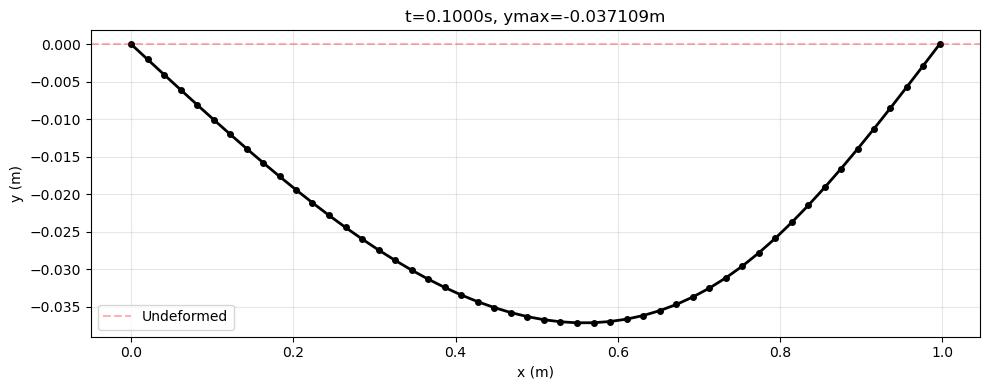

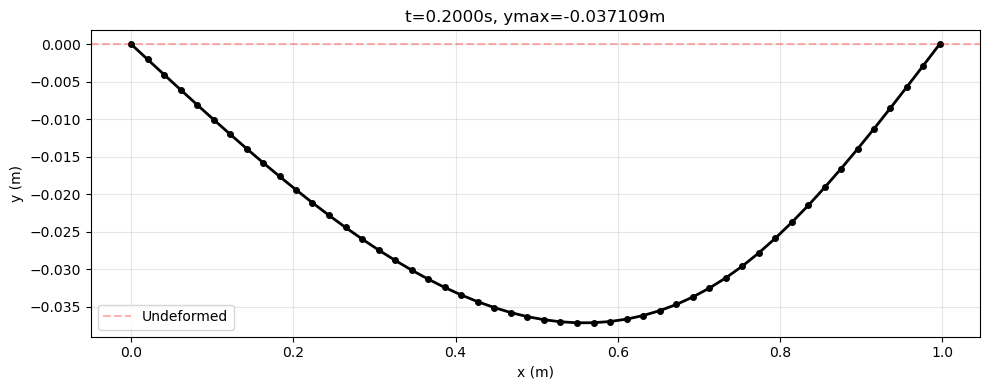

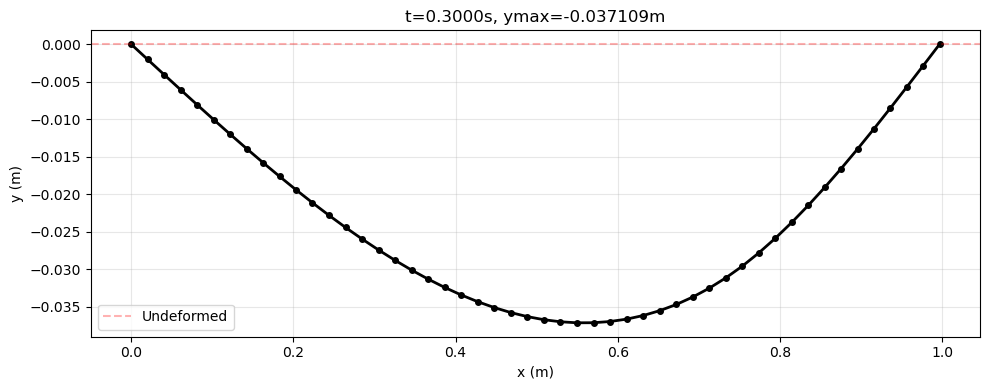

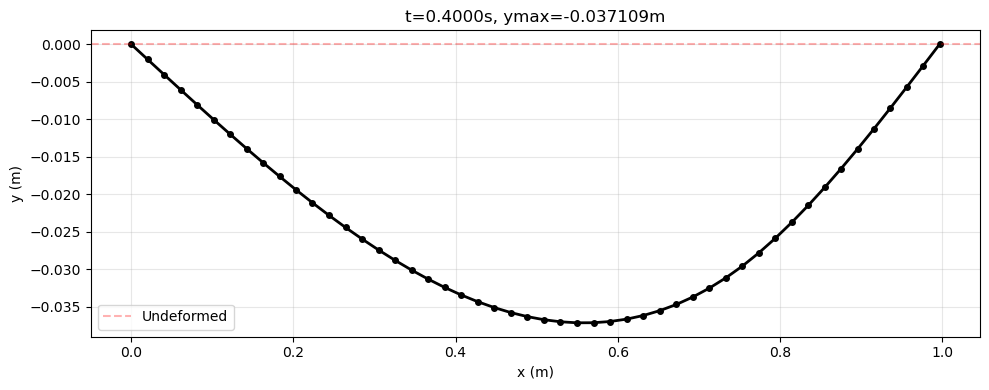

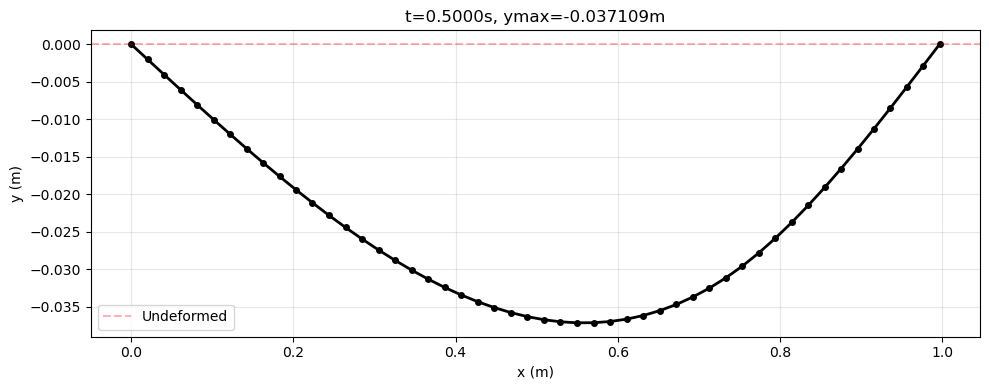

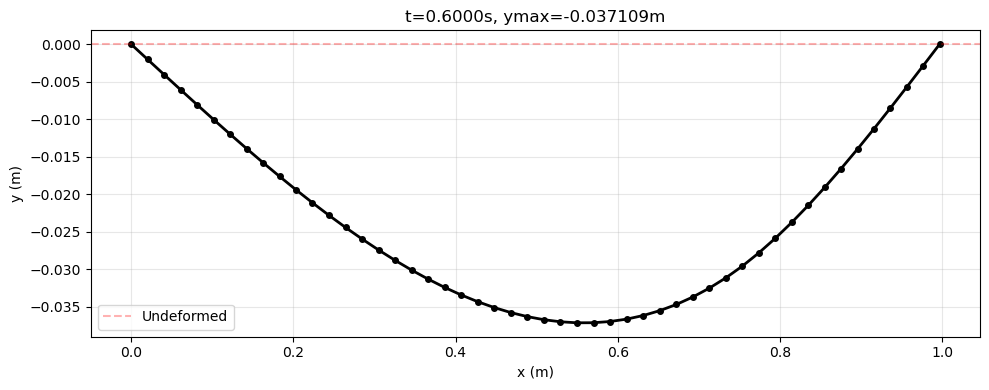

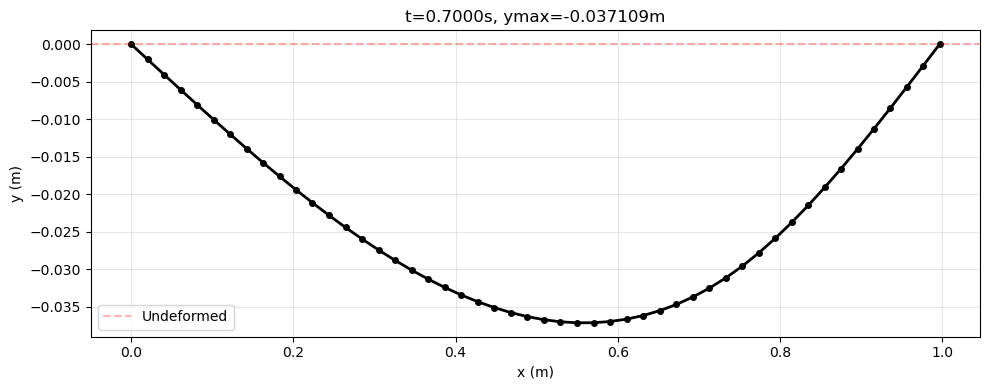

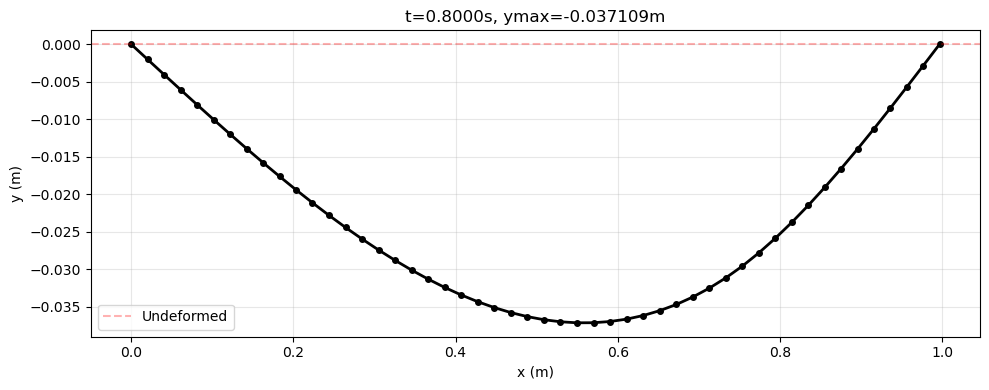

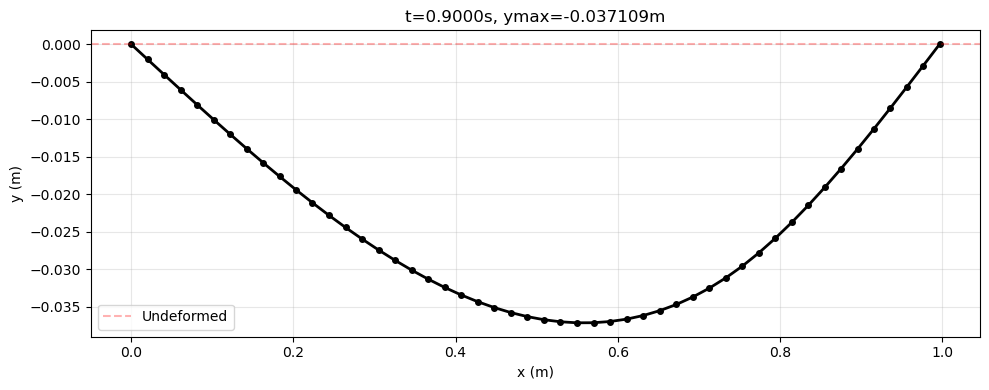

Simulation complete. Final ymax = -0.037109 m


In [78]:
# Number of steps
Nsteps = round(totalTime / dt)

ctime = 0  # Current time

# Store the maximum vertical displacement (ymax) over time
all_ymax = np.zeros(Nsteps)
all_time = np.zeros(Nsteps)

all_ymax[0] = 0
all_time[0] = 0

# Loop over the time steps
for timeStep in range(1, Nsteps):

    q_new, error = objfun(q0, u0, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL, N)
    if error < 0:
        print('Could not converge.')
        break

    u_new = (q_new - q0) / dt
    ctime += dt

    # Find maximum vertical displacement
    y_coords = q_new[1::2]  # Extract all y-coordinates
    ymax = np.min(y_coords)
    
    all_ymax[timeStep] = ymax
    all_time[timeStep] = ctime

    q0 = q_new.copy()
    u0 = u_new.copy()

    # Plot
    if timeStep % plotStep == 0:
        x_arr = q_new[::2]  # q[0], q[2], q[4]
        y_arr = q_new[1::2]  # q[1], q[3], q[5]

        plt.figure(1, figsize=(10, 4))
        plt.clf()
        plt.plot(x_arr, y_arr, 'ko-', linewidth=2, markersize=4)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, label='Undeformed')
        plt.title(f't={ctime:.4f}s, ymax={ymax:.6f}m')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

print(f"Simulation complete. Final ymax = {all_ymax[-1]:.6f} m")

Theoretical ymax (Euler beam): -0.037419 m
Simulated ymax (final): -0.037109 m
Difference: 3.098644e-04 m
Relative error: 0.83%


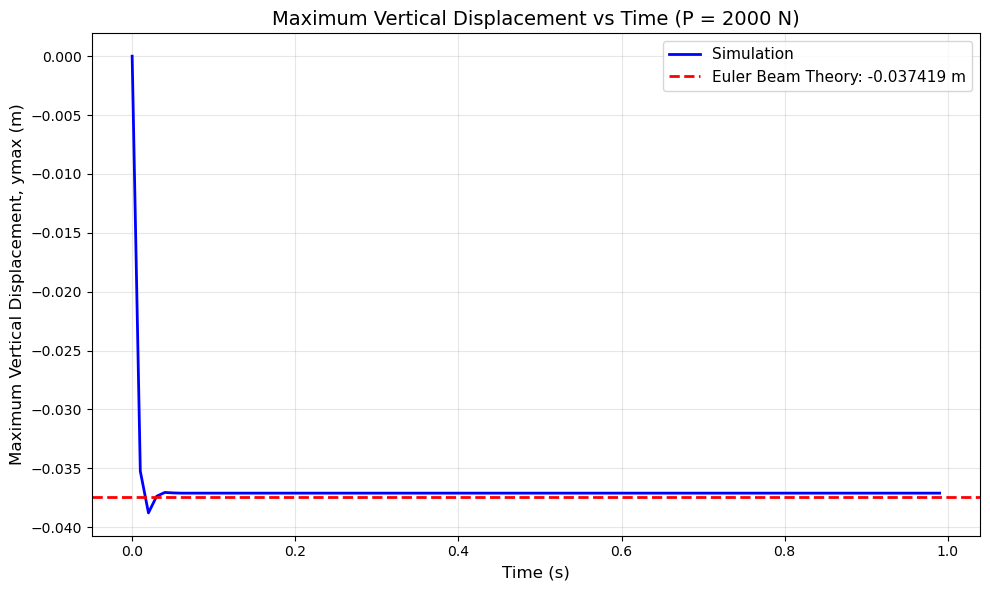


Steady state reached at t ≈ 0.050 s
Running 50 simulations for P ranging from 20 N to 20,000 N


<Figure size 640x480 with 0 Axes>

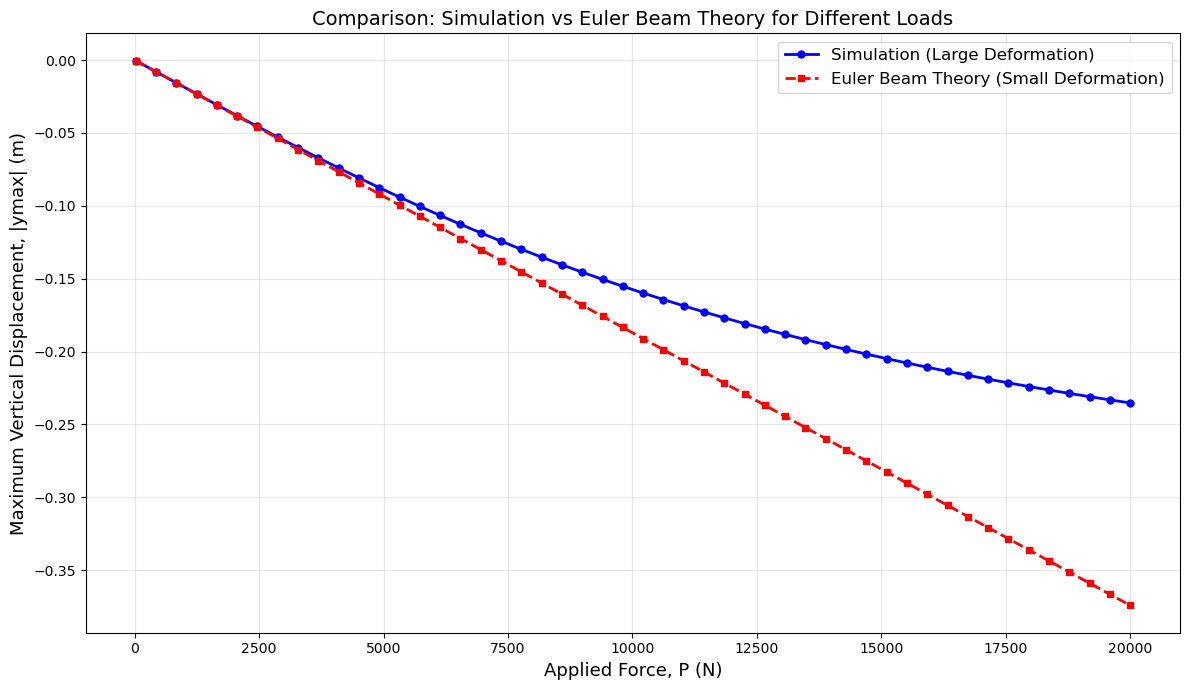

Solutions begin to diverge (>5% error) at P ≈ 5320.8 N
Relative error at this point: 5.52%


<Figure size 640x480 with 0 Axes>

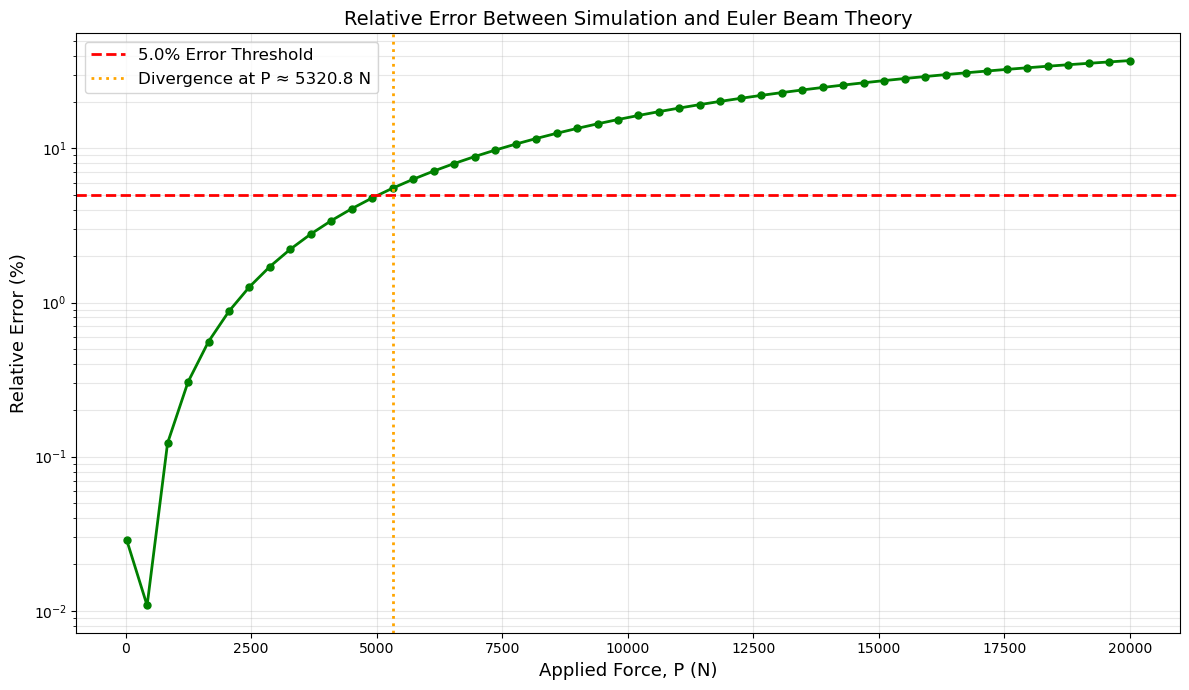

  Simulation ymax: -0.235256 m
  Theory ymax: -0.374192 m
  Relative error: 37.13%


<Figure size 640x480 with 0 Axes>

In [ ]:
# Task 1: Plot ymax as a function of time and compare with Euler beam theory

# Calculate theoretical ymax using Euler beam theory (Equation 5)
def euler_beam_ymax(P_val, d_val, l_val, E_val, I_val):
    """
    Calculate maximum deflection using Euler beam theory
    ymax = P*c*(l^2 - c^2)^1.5 / (9*sqrt(3)*E*I*l)
    where c = min(d, l-d)
    """
    c = min(d_val, l_val - d_val)
    ymax_theory = P_val * c * (l_val**2 - c**2)**1.5 / (9 * np.sqrt(3) * E_val * I_val * l_val)
    return -ymax_theory  # Negative because deflection is downward

# Calculate theoretical value for current P
ymax_theory = euler_beam_ymax(P, actual_d, RodLength, E, I)

print(f"Theoretical ymax (Euler beam): {ymax_theory:.6f} m")
print(f"Simulated ymax (final): {all_ymax[-1]:.6f} m")
print(f"Difference: {abs(all_ymax[-1] - ymax_theory):.6e} m")
print(f"Relative error: {abs((all_ymax[-1] - ymax_theory) / ymax_theory * 100):.2f}%")

# Plot ymax vs time
plt.figure(2, figsize=(10, 6))
plt.plot(all_time, all_ymax, 'b-', linewidth=2, label='Simulation')
plt.axhline(y=ymax_theory, color='r', linestyle='--', linewidth=2, label=f'Euler Beam Theory: {ymax_theory:.6f} m')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Maximum Vertical Displacement, ymax (m)', fontsize=12)
plt.title('Maximum Vertical Displacement vs Time (P = 2000 N)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Check if ymax reaches steady state
steady_state_value = all_ymax[-1]
tolerance_ss = 0.001 * abs(steady_state_value)
# Find when it reaches steady state (within 0.1% of final value)
for i in range(len(all_ymax)-1, -1, -1):
    if abs(all_ymax[i] - steady_state_value) > tolerance_ss:
        steady_state_time = all_time[i+1]
        break
else:
    steady_state_time = 0

print(f"\nSteady state reached at t ≈ {steady_state_time:.3f} s")

# Task 2: Parametric study - Compare simulation vs Euler beam theory for different P values
# Demonstrate the benefit of simulation over beam theory for large deformations

print("Running 50 simulations for P ranging from 20 N to 20,000 N")

# Define range of P values
P_values = np.linspace(20, 20000, 50)  # 50 points from 20 N to 20,000 N

# Arrays to store results
ymax_simulation = np.zeros(len(P_values))
ymax_theory_array = np.zeros(len(P_values))

# Run simulation for each P value
for idx, P_test in enumerate(P_values):
    # Update external force
    W_test = np.zeros(2 * N)
    W_test[2*forceNodeIdx + 1] = -P_test
    
    # Reset initial conditions
    q_test = np.zeros(2 * N)
    for c in range(N):
        q_test[2*c] = nodes[c, 0]
        q_test[2*c+1] = nodes[c, 1]
    
    u_test = np.zeros(2 * N)
    
    # Simulate to steady state (only final value needed)
    Nsteps_test = round(totalTime / dt)
    
    for timeStep in range(1, Nsteps_test):
        q_new_test, error = objfun(q_test, u_test, dt, tol, maximum_iter, 
                                    m, mMat, EI, EA, W_test, C, deltaL, N)
        if error < 0:
            print(f'Could not converge for P = {P_test:.1f} N')
            ymax_simulation[idx] = np.nan
            break
        
        u_new_test = (q_new_test - q_test) / dt
        q_test = q_new_test.copy()
        u_test = u_new_test.copy()
    
    # Get final ymax
    if error >= 0:
        y_coords_test = q_new_test[1::2]
        ymax_simulation[idx] = np.min(y_coords_test)
    
    # Calculate theoretical value
    ymax_theory_array[idx] = euler_beam_ymax(P_test, actual_d, RodLength, E, I)
    

# Plot P vs ymax (both simulation and theory)
plt.figure(3, figsize=(12, 7))
plt.plot(P_values, ymax_simulation, 'b-o', linewidth=2, markersize=5, label='Simulation (Large Deformation)')
plt.plot(P_values, ymax_theory_array, 'r--s', linewidth=2, markersize=5, label='Euler Beam Theory (Small Deformation)')
plt.xlabel('Applied Force, P (N)', fontsize=13)
plt.ylabel('Maximum Vertical Displacement, |ymax| (m)', fontsize=13)
plt.title('Comparison: Simulation vs Euler Beam Theory for Different Loads', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Calculate relative error and find where they diverge
relative_error = np.abs((ymax_simulation - ymax_theory_array) / ymax_theory_array) * 100

# Find where error exceeds 5% (commonly used threshold for "divergence")
divergence_threshold = 5.0  # percent
divergence_idx = np.where(relative_error > divergence_threshold)[0]

if len(divergence_idx) > 0:
    P_diverge = P_values[divergence_idx[0]]
    error_at_diverge = relative_error[divergence_idx[0]]
    print(f"Solutions begin to diverge (>5% error) at P ≈ {P_diverge:.1f} N")
    print(f"Relative error at this point: {error_at_diverge:.2f}%")
else:
    print("\nSolutions remain within 5% agreement across the entire range.")

# Plot relative error
plt.figure(4, figsize=(12, 7))
plt.semilogy(P_values, relative_error, 'g-o', linewidth=2, markersize=5)
plt.axhline(y=divergence_threshold, color='r', linestyle='--', linewidth=2, 
            label=f'{divergence_threshold}% Error Threshold')
if len(divergence_idx) > 0:
    plt.axvline(x=P_diverge, color='orange', linestyle=':', linewidth=2, 
                label=f'Divergence at P ≈ {P_diverge:.1f} N')
plt.xlabel('Applied Force, P (N)', fontsize=13)
plt.ylabel('Relative Error (%)', fontsize=13)
plt.title('Relative Error Between Simulation and Euler Beam Theory', fontsize=14)
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"  Simulation ymax: {ymax_simulation[-1]:.6f} m")
print(f"  Theory ymax: {ymax_theory_array[-1]:.6f} m")
print(f"  Relative error: {relative_error[-1]:.2f}%")